In [91]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor


In [ ]:
# 1. Getting data from  
originalData = pd.read_csv(Path("../datasets/housing/housing.csv"))
print(originalData.head())
originalData.info()

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64


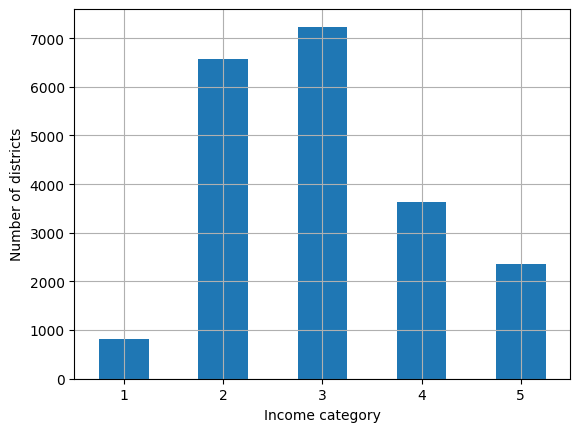

In [37]:
# Find the range of median income (Categories) with more numbers of districts
originalData["income_cat"] = pd.cut(originalData["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
originalData["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
print(originalData["income_cat"].value_counts().sort_index())
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()
plt.close()

In [ ]:
#2.  Split Training and Test
# Stratification ensures that the distribution of the ‚Äúincome_cat‚Äù variable in the training and test sets is similar to that of the original set.
# This is important when there is a categorical variable that influences the model and has unbalanced distributions.
strat_train_set, strat_test_set = train_test_split(originalData, test_size=0.2, stratify=originalData["income_cat"], random_state=42)

# Also we can use StratifiedShuffleSplit to create N training and test sets.
# By using n_splits=10, 10 different partitions are created, allowing the stability of the model to be evaluated on different subsets of the data.
# This is useful for techniques such as cross-validation (For now we are not going to use it).
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(originalData, originalData["income_cat"]):
    strat_train_set_n = originalData.iloc[train_index]
    strat_test_set_n = originalData.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])


# Finally we can remove income_cat because we only use it for the stratify
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


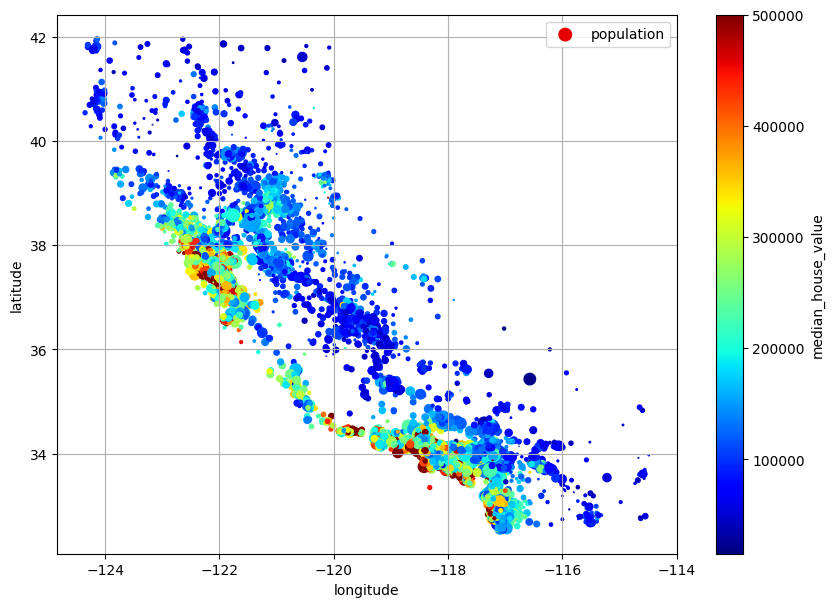

In [ ]:
# 3. Pre analysis of the data
# Let's plot the training data

# Next, you look at the housing prices (Figure 2-13). 
# The radius of each circle represents the district‚Äôs population (option s), 
# and the color represents the price (option c). 
# Here you use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):‚Å†8
preAnalisys_train = strat_train_set.copy()
preAnalisys_train.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=preAnalisys_train["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()
plt.close()

In [40]:
# Now let's check the correlation of  median house value with the other numberic features 
corr_matrix = preAnalisys_train.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

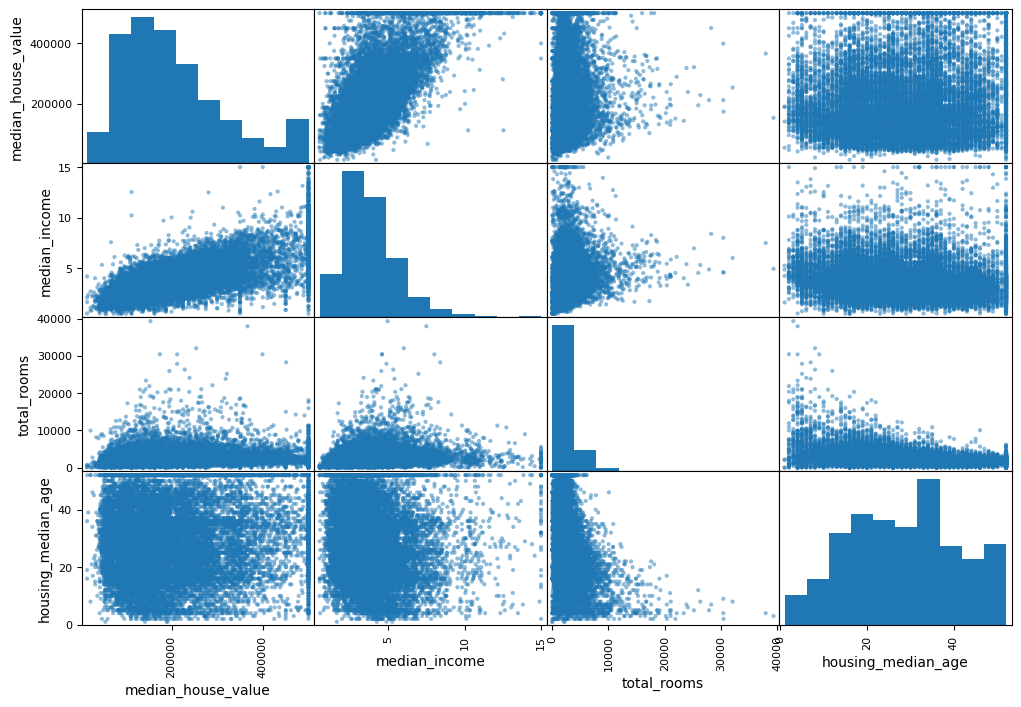

In [41]:
# Other way to check the correlation is using scatter matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(preAnalisys_train[attributes], figsize=(12, 8))
plt.show()
plt.close()

In [42]:
# Now we'll create new features.
# Now rooms_per_house has a better correlation

preAnalisys_train["rooms_per_house"] = preAnalisys_train["total_rooms"] / preAnalisys_train["households"]             # mean total rooms per household
preAnalisys_train["bedrooms_ratio"] = preAnalisys_train["total_bedrooms"] / preAnalisys_train["total_rooms"]          # mean total bedrooms per total rooms
preAnalisys_train["people_per_house"] = preAnalisys_train["population"] / preAnalisys_train["households"]             # mean population per household


corr_matrix = preAnalisys_train.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [ ]:
# 4. Pre-processing for Machine Learning

# Split label and features:
x_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

#
# Num√©rica (Cuantitativa) 
#   Discreta: Solo pueden tomar valores espec√≠ficos (generalmente enteros). Se obtienen por conteo. Ejemplo: n√∫mero de hijos, cantidad de autos en un estacionamiento.
#   Continua: Pueden tomar cualquier valor dentro de un rango, Se pueden medir con una precisi√≥n infinita. Ejemplo: altura, peso, temperatura, ingresos.

# Categ√≥rica (Cualitativa)	
#   Nominal: No tienen un orden natural. Son simplemente nombres o etiquetas. Ejemplo: color de ojos (azul, verde, marr√≥n), pa√≠s de origen, tipo de mascota.
#   Ordinal: Tienen un orden o jerarqu√≠a, pero la diferencia entre categor√≠as no es uniforme. Ejemplo: nivel de educaci√≥n (primaria, secundaria, universidad), satisfacci√≥n del cliente (bajo, medio, alto).

In [71]:
# Fisrt we're working with Quantitative Features
# Checking Null Values

# Checking total_bedrooms this has null vales. 
x_train.info()

# We can take three actions:
# 1. Replace the null values  with mean, min, max, so on.
# 2. Remove these samples with null value
# 3. Delete the entire feature

# An Imputer apply a strategy to convert the null values of the dataset.
imputer = SimpleImputer(strategy="median")
x_train_numeric = x_train.select_dtypes(include=[np.number])
imputer.fit(x_train_numeric)
imputer.statistics_   
X = imputer.transform(x_train_numeric)

# It replaces the null values with the median of the corresponding feature.
x_train_numeric = pd.DataFrame(X, columns=x_train_numeric.columns, index=x_train_numeric.index)
x_train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64

In [45]:
# Checking Categorical Features
x_train_cat = x_train[["ocean_proximity"]]


# Getting the Categories
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(x_train_cat)
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
# However, most machine learning algorithms work better with numerical features and we want to
# Convert Categories to vector
#  Dense matrix                                                    Sparse matrix  
#  [0. 0. 0. 1. 0.]  # one-hot vector for category 0: "<1H OCEAN"  => 0, 3 = 1
#  [1. 0. 0. 0. 0.]  # one-hot vector for category 1: "INLAND"     => 1, 0 = 1 
#  [0. 1. 0. 0. 0.]  # one-hot vector for category 2: "ISLAND"     => 2, 1 = 1
cat_encoder = OneHotEncoder()
x_train_cat_1hot = cat_encoder.fit_transform(x_train_cat)

print(x_train_cat_1hot)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>
  Coords	Values
  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 3)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 3)	1.0
  (18, 1)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 4)	1.0
  (22, 1)	1.0
  (23, 3)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 0)	1.0
  (16490, 3)	1.0
  (16491, 1)	1.0
  (16492, 4)	1.0
  (16493, 4)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 0)	1.0
  (16498, 0)	1.0
  (16499, 4)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 0)	1.0
  (16503, 0)	1.0
  (16504, 0)	1.0
  (16505, 0)	1.0
  (16506, 1)	1.0
  (16507, 0)	1.0
  (16508, 1)	1.0
  (16509, 4)	1.0
  (16510, 0)	1.0
  (16511, 4)	1.0


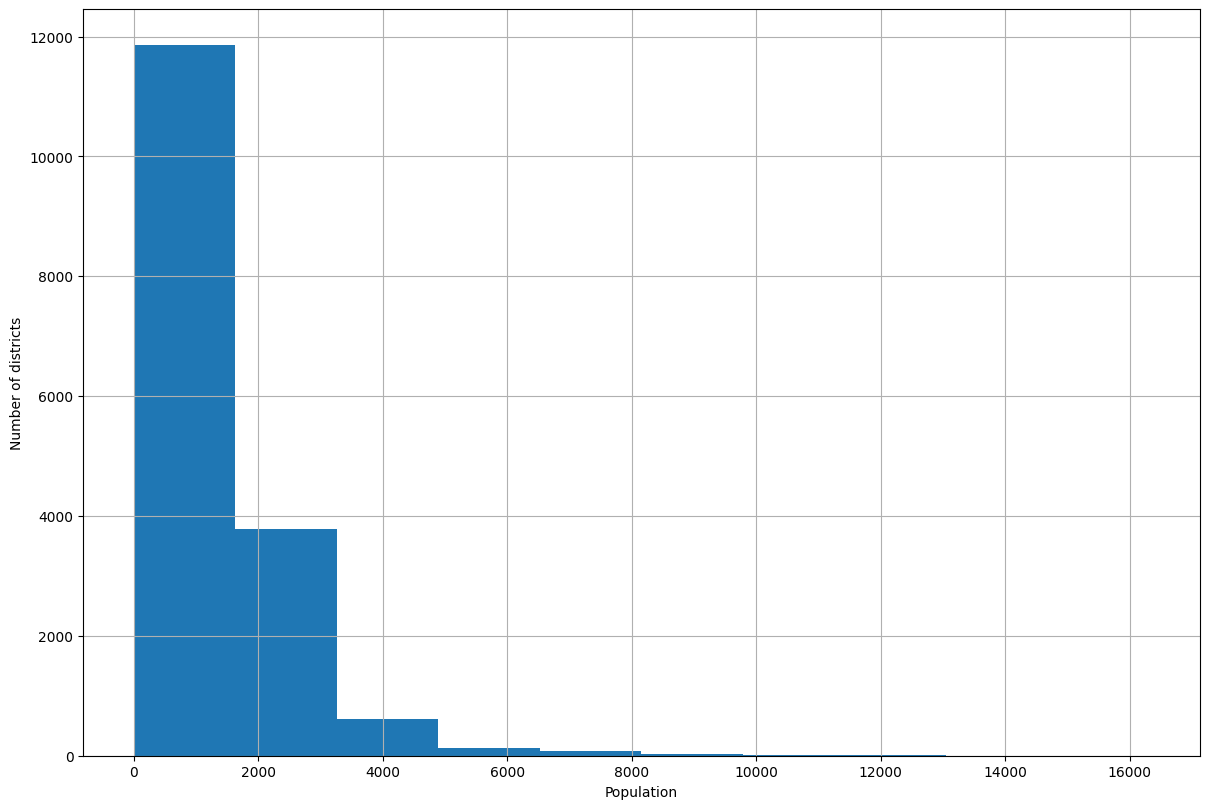

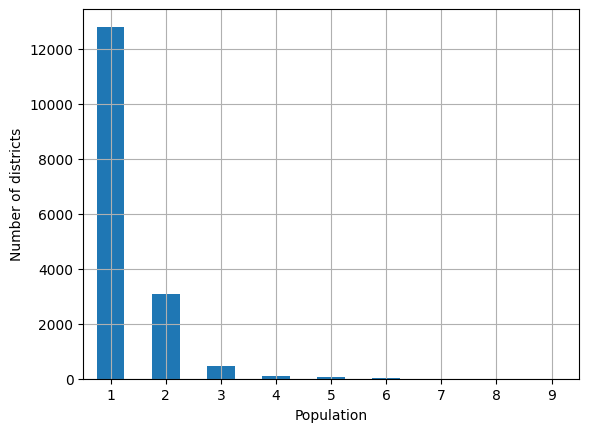

In [ ]:
# 5. Review High tail features
## Before apply the Feacture scaling (next topic).
# When a feature‚Äôs distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare),
# both min-max scaling and standardization will squash most values into a small range. 
# Machine learning models generally don‚Äôt like this at all
# So before scaling features, you should try the following:
# 1. For example, a common way to do this for positive features with a heavy tail to the right is to replace the feature with its square root (or raise the feature to a power between 0 and 1)
# 2. If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help
# the population feature roughly follows a power law: districts with 10,000 inhabitants are only 10 times less frequent than districts with 1,000 inhabitants, not exponentially less frequent. Figure 2-17 shows how much better this feature looks when you compute its log: it‚Äôs very close to a Gaussian distribution (i.e., bell-shaped).


# Showing the population distribution with high tail.
x_train_numeric["population"].hist(bins=10, figsize=(12, 8))
plt.tight_layout() # Adjust the subplots to give more space between them
plt.xlabel("Population")
plt.ylabel("Number of districts")
plt.show()
plt.close()

# Showing the population distribution with high tail unsing bin personalized with min and max values
min_val = x_train_numeric['population'].min()
max_val = x_train_numeric['population'].max()
bins = np.linspace(min_val, max_val, 10)

x_train_numeric["population_count"] = pd.cut(x_train_numeric["population"], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9]) 
x_train_numeric["population_count"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Population")
plt.ylabel("Number of districts")
plt.show()
plt.close()

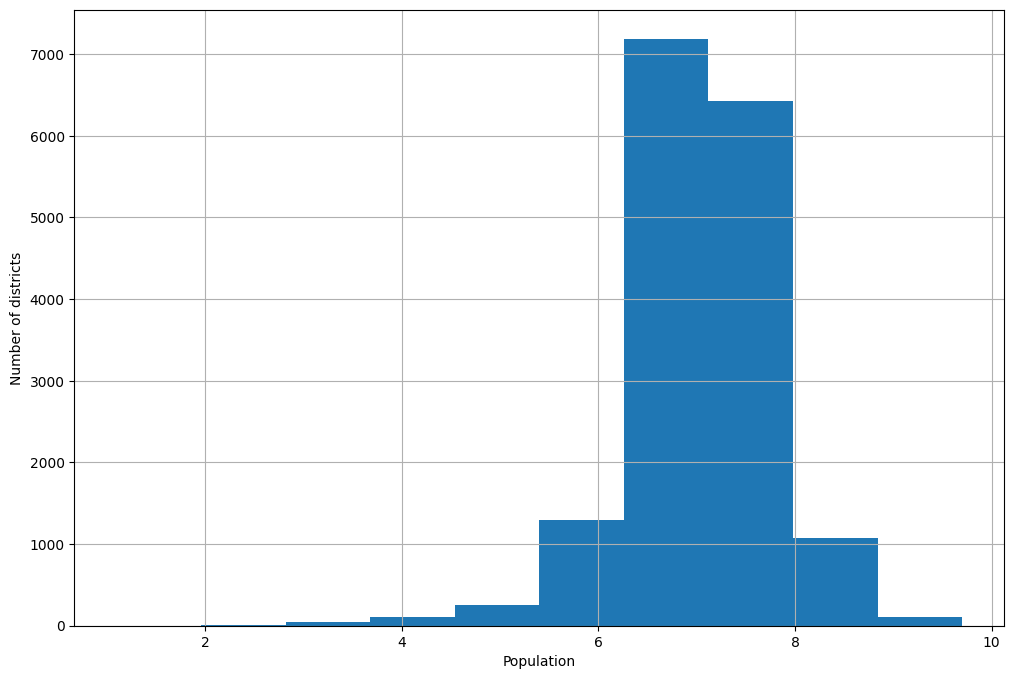

In [48]:
# Applying the log to the population feature
# Now this looks more as a normal distribution
x_train_numeric["population_log"] = np.log(x_train_numeric["population"])
x_train_numeric["population_log"].hist(bins=10, figsize=(12, 8))
plt.xlabel("Population")
plt.ylabel("Number of districts")
plt.show()
plt.close()


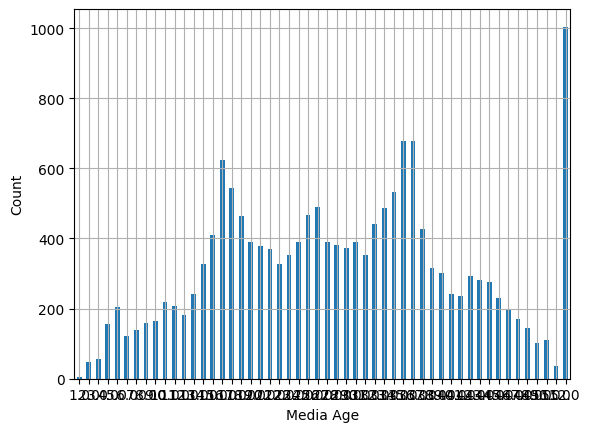

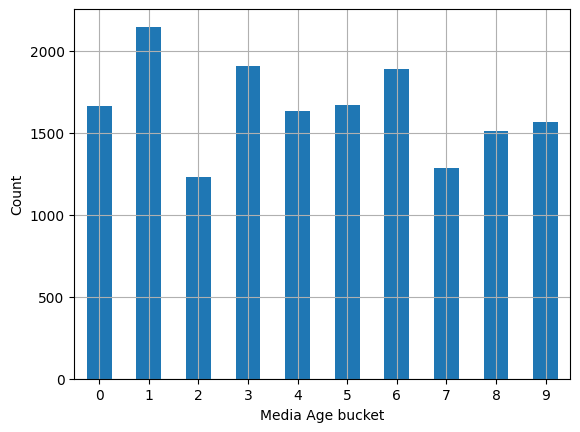

In [ ]:

# 5.1 Review High tail features applying bucketing
# Showing housing_median_age distribution with high tail.
# S√≠, esta distribuci√≥n podr√≠a considerarse bimodal, aunque no tenga dos picos exactamente del mismo valor.
x_train_numeric["housing_median_age"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Media Age")
plt.ylabel("Count")
plt.show()
plt.close()

num_buckets = 10
x_train_numeric["median_age_bucket"] = pd.qcut(x_train_numeric["housing_median_age"], q=num_buckets, labels=False)


# üîπ Paso a paso:
# 1Ô∏è‚É£ median_income: Es la columna que queremos dividir en grupos.
# 2Ô∏è‚É£ q=num_buckets: Especificamos que queremos 10 grupos (percentiles del 10%, 20%, 30%, etc.).
# 3Ô∏è‚É£ labels=False: En lugar de devolver etiquetas de categor√≠as, devuelve n√∫meros enteros del 0 al 9 (uno por grupo).
# 4Ô∏è‚É£ Se almacena en income_bucket, una nueva columna que indica a qu√© grupo pertenece cada fila.

# This localiza the values of the median_income on the buckket number corresponding to the income_bucket
x_train_numeric["median_age_bucket"] 

x_train_numeric["median_age_bucket"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Media Age bucket")
plt.ylabel("Count")
plt.show()
plt.close()


In [51]:
# this sumarizes the number of districts in each bucket.  We can use this value instannce of high tail feacture values of the column
x_train_numeric["median_age_bucket"].value_counts().sort_index()

median_age_bucket
0    1663
1    2147
2    1230
3    1910
4    1634
5    1670
6    1891
7    1288
8    1513
9    1566
Name: count, dtype: int64

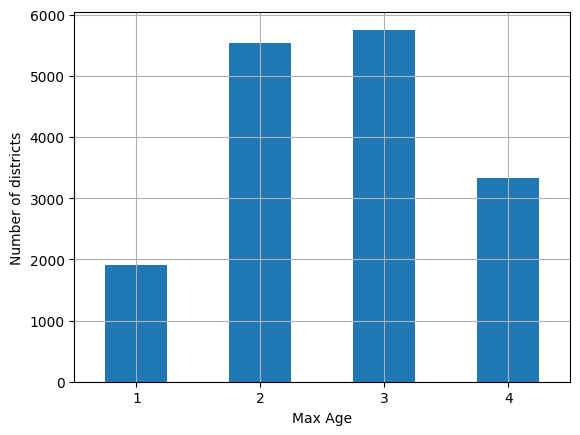

<COOrdinate sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>
  Coords	Values
  (0, 4)	1.0
  (1, 4)	1.0
  (2, 3)	1.0
  (3, 1)	1.0
  (4, 3)	1.0
  (5, 4)	1.0
  (6, 3)	1.0
  (7, 3)	1.0
  (8, 1)	1.0
  (9, 1)	1.0
  (10, 1)	1.0
  (11, 4)	1.0
  (12, 3)	1.0
  (13, 1)	1.0
  (14, 3)	1.0
  (15, 2)	1.0
  (16, 4)	1.0
  (17, 2)	1.0
  (18, 0)	1.0
  (19, 4)	1.0
  (20, 3)	1.0
  (21, 4)	1.0
  (22, 0)	1.0
  (23, 4)	1.0
  (24, 2)	1.0
  :	:
  (16487, 0)	1.0
  (16488, 2)	1.0
  (16489, 3)	1.0
  (16490, 0)	1.0
  (16491, 2)	1.0
  (16492, 2)	1.0
  (16493, 2)	1.0
  (16494, 0)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 2)	1.0
  (16498, 4)	1.0
  (16499, 3)	1.0
  (16500, 1)	1.0
  (16501, 3)	1.0
  (16502, 0)	1.0
  (16503, 3)	1.0
  (16504, 2)	1.0
  (16505, 2)	1.0
  (16506, 3)	1.0
  (16507, 4)	1.0
  (16508, 1)	1.0
  (16509, 0)	1.0
  (16510, 3)	1.0
  (16511, 4)	1.0


In [ ]:
# 5.2 Review Multimodal features applying bucketing
#  When a feature has a multimodal distribution (i.e., with two or more clear peaks, called modes), such as the housing_median_age feature, it can also be helpful to bucketize it, 
# but this time treating the bucket IDs as categories, rather than as numerical values. This means that the bucket indices must be encoded, 
# for example using a OneHotEncoder (so you usually don‚Äôt want to use too many buckets).
#  This approach will allow the regression model to more easily learn different rules for different ranges of this feature value. 
# For example, perhaps houses built around 35 years ago have a peculiar style that fell out of fashion, and therefore they‚Äôre cheaper than their age alone would suggest.

# Showing the population distribution with high tail unsing bin personalized with min and max values
min_val = x_train_numeric['housing_median_age'].min()
max_val = x_train_numeric['housing_median_age'].max()
bins = np.linspace(min_val, max_val, 5)


x_train_numeric["housing_median_age_count"] = pd.cut(x_train_numeric["housing_median_age"], bins=bins, labels=[1, 2, 3, 4])

x_train_numeric["housing_median_age_count"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Max Age")
plt.ylabel("Number of districts")
plt.show()
plt.close()

# Bucketization: Convertir los valores en categor√≠as (bins) usando KBinsDiscretizer.

discretizer = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')
median_age_binned = discretizer.fit_transform(x_train_numeric[["housing_median_age"]])
print(coo_matrix(median_age_binned))




In [ ]:
# 5.3 Review Multimodal features create new features with radial basis function (RBF)
# The housing_median_age feature has a multimodal distribution, with two clear peaks at 10 and 35 years.

# Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), 
# representing the similarity between the housing median age and that particular mode. 
# The similarity measure is typically computed using a radial basis function (RBF)‚Äîany function that depends only on the distance between the input value and a fixed point. 
# The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. 
# For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation exp(‚ÄìŒ≥(x ‚Äì 35)¬≤). 
# The hyperparameter Œ≥ (gamma) determines how quickly the similarity measure decays as x moves away from 35. 
# Using Scikit-Learn‚Äôs rbf_kernel() function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

age_simil_35 = rbf_kernel(x_train_numeric[["housing_median_age"]], [[35]], gamma=0.1)



array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

In [ ]:
# So far we‚Äôve only looked at the input features, but the target values may also need to be transformed. For example, if the target distribution has a heavy tail,
#  you may choose to replace the target with its logarithm. But if you do, the regression model will now predict the log of the median house value, 
# not the median house value itself. You will need to compute the exponential of the model‚Äôs prediction if you want the predicted median house value.

# Luckily, most of Scikit-Learn‚Äôs transformers have an inverse_transform() method, making it easy to compute the inverse of their transformations. 
# For example, the following code example shows how to scale the labels using a StandardScaler (just like we did for inputs), 
# then train a simple linear regression model on the resulting scaled labels and use it to make predictions on some new data, 
# which we transform back to the original scale using the trained scaler‚Äôs inverse_transform() method. 
# Note that we convert the labels from a Pandas Series to a DataFrame, since the StandardScaler expects 2D inputs. 
# Also, in this example we just train the model on a single raw input feature (median income), for simplicity:


target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(y_train.to_frame())

model = LinearRegression()
model.fit(x_train_numeric[["median_income"]], scaled_labels)
some_new_data = x_train_numeric[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
# show the reversed values of the median house income 
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [ ]:
# The idea is to use the transformed target regressor to do this automatically.
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(x_train_numeric[["median_income"]], y_train)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [ ]:
### 6. Feature Scaling Transformation ###

# Most of Machine learning algoritms don't perform so well when the input numerical attributes have a diferent scales
# Note that while the training set values will always be scaled to the specified range, if new data contains outliers, 
# these may end up scaled outside the range. If you want to avoid this, just set the clip hyperparameter to True.

# Min-max scaling (many people call this normalization) is the simplest: 
# for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. 
# This is performed by subtracting the min value and dividing by the difference between the min and the max. 
# Scikit-Learn provides a transformer called MinMaxScaler for this. 
# It has a feature_range hyperparameter that lets you change the range if, 
# for some reason, you don‚Äôt want 0‚Äì1 (e.g., neural networks work best with zero-mean inputs, so a range of ‚Äì1 to 1 is preferable). It‚Äôs quite easy to use:

# Also named Normalization
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_normalized = min_max_scaler.fit_transform(x_train_numeric)
x_train_normalized

array([[-0.60851927,  0.11702128,  1.        , ..., -1.        ,
         0.45664772, -0.77777778],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -1.        ,
         0.25634679,  0.77777778],
       [-0.51926978,  0.23617021,  0.25490196, ..., -1.        ,
         0.21686407, -0.55555556],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.75      ,
         0.59145599,  0.33333333],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -1.        ,
         0.47765484,  0.33333333],
       [-0.60649087,  0.08723404,  0.68627451, ..., -1.        ,
         0.26186732, -0.11111111]], shape=(16512, 11))

In [ ]:

## Standarization
# Standardization is different: first it subtracts the mean value (so standardized values have a zero mean), 
# then it divides the result by the standard deviation (so standardized values have a standard deviation equal to 1). 
# Unlike min-max scaling, standardization does not restrict values to a specific range. 
# However, standardization is much less affected by outliers. 
# For example, suppose a district has a median income equal to 100 (by mistake), instead of the usual 0‚Äì15. Min-max scaling to the 0‚Äì1 range would map this outlier down to 1 and it would crush all the other values down to 0‚Äì0.15, 
# whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization:

std_scaler = StandardScaler()
x_train_standard = std_scaler.fit_transform(x_train_numeric)
x_train_standard

array([[-1.42303652,  1.0136059 ,  1.86111875, ..., -0.4570703 ,
         0.45690625, -1.21831552],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.4570703 ,
        -0.71165416,  1.21861069],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.4570703 ,
        -0.94199727, -0.87018321],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.158231  ,
         1.24338084,  0.52234606],
       [ 0.58639727, -0.73960483,  0.66925745, ..., -0.4570703 ,
         0.57946226,  0.52234606],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.4570703 ,
        -0.67944724, -0.17391857]], shape=(16512, 11))

# 